# Quantum Monte Carlo
This file showcases all the code that was used in the AMS553 final project

Author: David Miloschewsky

In [1]:
# Imports
import qiskit as qi
from qiskit_finance.circuit.library import NormalDistribution
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit.algorithms import EstimationProblem, IterativeAmplitudeEstimation
from qiskit.transpiler import PassManager
from qiskit_machine_learning.algorithms.distribution_learners.qgan import QGAN
from qiskit.circuit.library import TwoLocal
from qiskit.transpiler.passes import Unroller
import matplotlib.pyplot as plt
import numpy as np
import warnings
from tqdm import tqdm
import math
from typing import List
warnings.filterwarnings("ignore")

## Probability distribution in a quantum state
In this section we show several ways to insert a probability distribution into the amplitudes of N qubits.

First we create an algorithm to load an arbitrary distribution and then we show some Qiskit commands that load a distribution in a simple manner.

In [2]:
# Function to arbitrarily load a distribution
def prob_to_theta(p: float):
    return 2 * np.arcsin(np.sqrt(p))

def get_zero_prob(vec: list):
    """
    Returns the probability that given a vector, the elements with zero in the first bit are 0
    """
    return sum(vec[:len(vec)//2])

def add_to_circuit(qc: qi.QuantumCircuit, distr, i, n, prev_p, prev_bits):
    """
    Recursive function which adds the necessary 
    """
    p = get_zero_prob(distr)
    if i==n or abs(p)<0.001:
        return qc
    # Adding the necessary gates
    if i == 0:
        qc.ry(prob_to_theta(p), [0])
    else:
        for j in prev_bits:
            qc.x(j)
        qc.cry(prob_to_theta(p/prev_p), list(range(i)), [i])
        for j in prev_bits:
            qc.x(j)
    # Using recursion
    qc = add_to_circuit(qc, distr[:len(distr)//2], i+1, n, 1-p, prev_bits)
    qc = add_to_circuit(qc, distr[len(distr)//2:], i+1, n, p, prev_bits + [i])
    return qc

def arbitrary_distr(disc_distr: List[int]):
    """
    The following function creates an arbitrary state that holds the discretized
    values of dicret_distr
    """
    # Normalizing
    n = math.log(len(disc_distr), 2)
    if n!=int(n):
        n = math.ceil(n)
        while len(disc_distr)!= 2**n:
            disc_distr.append(0)
    disc_distr = np.array(disc_distr)/sum(disc_distr)

    # Creating the circuit
    circuit = qi.QuantumCircuit(n)
    circuit = add_to_circuit(circuit, disc_distr, 0, n, 1, [])
    return circuit

In [3]:
# Number of qubits
n = 4

# Uniform distribution
qUni = qi.QuantumRegister(n, 'q')
circuit = qi.QuantumCircuit(qUni)
circuit.h(qUni)

# Normal distribution
qNorm = NormalDistribution(n)

## Expectation & Variance calculation
In this section we present a quantum algorithm that computes the expectation and the variance of a distribution. It takes a N qubits with their amplitudes containing the probability distribution and outputs the expectation and variance by applying a function gate F and then using iterative quantum amplitude estimation.

In [15]:
# The gate for the expectation function

def gate_decompose(qc):
    """decompose circuit to evaluate cost"""
    pass_ = Unroller(["u3", "cx"])
    return PassManager(pass_).run(qc).count_ops()

class simAlg():
    def __init__(self, distr: qi.QuantumCircuit):
        """
        Creates the simulation algorithm object which combines
        the distribution and an extra quantum register
        """
        # Number of qubits in the circuit
        self.qubNum = distr.num_qubits + 1
        # The qubit which holds the information
        self.outReg = qi.QuantumCircuit(qi.QuantumRegister(1, 'output'))
        # Combination of the quantum circuits
        self.qc = distr.combine(self.outReg)
        # Creating a simulation instance
        sv_sim = qi.Aer.get_backend('aer_simulator')
        self.quantum_instance = qi.utils.QuantumInstance(sv_sim)
        # Key variables
        self.norm = 2**(self.qubNum-1)-1

    def run_qae(self, qc: qi.QuantumCircuit):
        """
        Runs the Iterative Quantum Amplitude Estimation algorithm on the
        last qubit in the circuit qi
        """
        problem = EstimationProblem(qc, objective_qubits=self.qubNum-1)
        ae = IterativeAmplitudeEstimation(
            epsilon_target=0.01,  # target accuracy
            alpha=0.05,
            quantum_instance=self.quantum_instance,
        )
        return ae.estimate(problem).estimation

    def run_algorithm(self, qc: qi.QuantumCircuit, f: qi.QuantumCircuit):
        """
        Running the algorithm by combining qc and f together
        """
        qcRun = qc.copy()
        qcRun = qcRun.compose(f.copy())
        return self.run_qae(qcRun), gate_decompose(qcRun.decompose())

    def cal_expectation(self):
        """
        Calculates the expectation of the distribution function
        using the algorithm
        """
        func = self.func_expectation()
        qae_res, decomp = self.run_algorithm(self.qc, func)
        return qae_res*self.norm, decomp

    def func_expectation(self):
        # Creating the function
        func = LinearAmplitudeFunction(self.qubNum-1, 1/self.norm, 0, [0,2**(self.qubNum-1)-1], [0,1])
        return func

    def cal_variance(self):
        # Calculating the expectation
        exp, decomp = self.cal_expectation()
        
        # Calculating function f(x)=x^2
        func = self.func_variance()
        qae_res, decomp2 = self.run_algorithm(self.qc, func)
        return 2*((qae_res-((exp/self.norm)**2))), {k:decomp[k] + decomp2[k] for k in decomp.keys()}

    def func_variance(self):
        n = self.qubNum-1
        func = LinearAmplitudeFunction(self.qubNum-1, 1/2**(n+3), -0.1, [0,2**(self.qubNum-1)-1], [0,1])
        func2 = LinearAmplitudeFunction(self.qubNum-1, 1/self.norm, 0, [0,2**(self.qubNum-1)-1], [0,1])
        func = func.compose(func2)
        return func
        

### Running Gate Big O Testing
We will run a test on the number of qubits used in the calculation of variance and expectation in order to create subsequent graphics

In [23]:
# Performing the gate calculation
expect_gate = []
variance_gate = []

compRange = range(1,40)

for j in tqdm(compRange):
    distribution = qi.QuantumCircuit(j)
    alg = simAlg(distribution)
    func = alg.func_variance()
    decomposition = gate_decompose(func.decompose())
    variance_gate.append(decomposition['u3'] + decomposition['cx'])
    func = alg.func_expectation()
    decomposition = gate_decompose(func.decompose())
    expect_gate.append(decomposition['u3'] + decomposition['cx'])


100%|██████████| 39/39 [00:07<00:00,  5.07it/s]


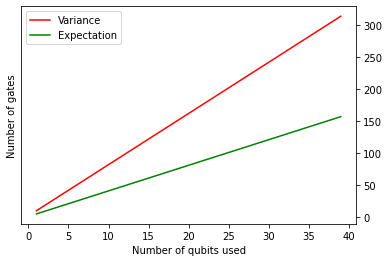

In [26]:
# Plotting the results
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = False
plt.plot(list(compRange), variance_gate, label='Variance', color='red')
plt.plot(list(compRange), expect_gate, label='Expectation', color='green')
plt.ylabel('Number of gates', )
plt.xlabel('Number of qubits used')
plt.legend(loc='upper left')
plt.show()

### Gate complexity of cGAN and Implemented
Below we run the comparison of the number of 'u3' and 'cx' gates in two algorithms:
-   A trained cGAN that mimics the normal distribution
-   A qiskit algorithm for the normal distribution

In [10]:
# Creating functions to train the circuit
def normalDataset(n: int):
    """
    Creates a random set of integers to train on
    """
    exp, normalData = 2**(n-1)-0.5, []
    for j in range(1000):
        r = np.random.normal(exp, 1)
        if r>0 and r<2**n:
            normalData.append(r)
    return normalData

def train_normal(n: int):
    """
    We attempt short training of the normal distribution
    We used the following article for inspiration:
    https://insidebigdata.com/2021/05/27/quantum-machine-learning-an-introduction-to-qgans/
    """
    trainDataset = np.array(normalDataset(n))
    num_qubits = [n]
    num_epochs = 10
    bounds = [0, (2**n)-1]
    sv_sim = qi.Aer.get_backend('aer_simulator')
    quantum_instance = qi.utils.QuantumInstance(sv_sim)
    # Training model
    distr = QGAN(trainDataset, bounds, num_qubits, num_epochs=num_epochs, snapshot_dir=None)

    # Running the training
    train_res = distr.run(quantum_instance)

    # Inserting the result into a quantum circuit
    q = qi.QuantumRegister(n)
    init_dist = qi.QuantumCircuit(q)
    var_form = TwoLocal(n, "ry", "cz", entanglement="circular", reps=1)
    g_circuit = init_dist.compose(var_form)
    theta = var_form.ordered_parameters

    circuit = g_circuit.assign_parameters(dict(zip(theta, train_res['params_g'])))
    return circuit

a = train_normal(2)

In [13]:
# Testing the complexity of the resulting models
qGAN_gates = []
finance_gates = []

testRange = range(1,10)

for j in tqdm(testRange):
    # Creating the models
    qGAN_model = train_normal(j)
    finance_model = NormalDistribution(j)
    # Measuring gate complexity
    decomposition = gate_decompose(qGAN_model.decompose())
    try:
        qGAN_gates.append(decomposition['u3'] + decomposition['cx'])
    except:
        qGAN_gates.append(decomposition['u3'])
    decomposition = gate_decompose(finance_model.decompose())
    try:
        finance_gates.append(decomposition['u3'] + decomposition['cx'])
    except:
        finance_gates.append(decomposition['u3'])


100%|██████████| 9/9 [03:45<00:00, 25.10s/it]


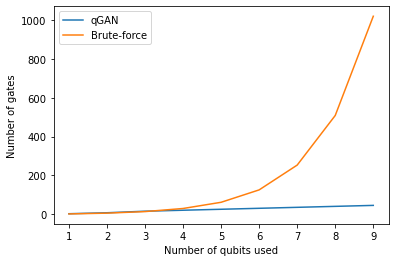

In [14]:
# Plotting our results
plt.plot(list(testRange), qGAN_gates, label='qGAN')
plt.plot(list(testRange), finance_gates, label='Brute-force')
plt.ylabel('Number of gates')
plt.xlabel('Number of qubits used')
plt.legend(loc='upper left')
plt.show()